In [1]:
library(modelr)
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


# Lecture 21: Classification and logistic regression

<div style="border: 1px double black; padding: 10px; margin: 10px">

**After today's lecture you will understand:**
* Fitting logistic regression models in R using `glm()`.
* Use the fitted model to predict outcome for new dataset.
* Ways to measure the accuracy of a binary classifier.
</div>



## Modeling with categorical outcomes
Last lecture we learned all about regression. In regression, we have a continuous outcome (height, population growth, etc.), and some predictors which could be either categorical or continuous. We built a function that predicts the mean of the outcome given the predictors, e.g.

$$
\mathbb{E}(y \mid x) = a_0 + a_1 x.
$$

For example, we fit the following model:

In [2]:
lm(price ~ carat, diamonds) %>% summary


Call:
lm(formula = price ~ carat, data = diamonds)

Residuals:
     Min       1Q   Median       3Q      Max 
-18585.3   -804.8    -18.9    537.4  12731.7 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -2256.36      13.06  -172.8   <2e-16 ***
carat        7756.43      14.07   551.4   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1549 on 53938 degrees of freedom
Multiple R-squared:  0.8493,	Adjusted R-squared:  0.8493 
F-statistic: 3.041e+05 on 1 and 53938 DF,  p-value: < 2.2e-16


This says that the average value of `log(price)` given `log(carat)` is 

$$8.449 + 1.676 \cdot \log(\text{carat})\quad\text{(avg. value of log(price))}$$

In today's lecture, we are going to look at a different kind of regression model, with the main difference being that our outcome is no longer a continuous variable like price or log(price). Instead, the outcome is a True/False variable which indicates whether or not some event happened.

## Deaths on the *RMS Titanic*
The [RMS Titanic](https://en.wikipedia.org/wiki/Titanic) famously sank on April 15, 1912 during its maiden voyage, killing about 2/3rds of its passengers. The `titanic` data set records the fates of everyone aboard.

In [4]:
data(Titanic)
titanic_df <- Titanic %>% as_tibble %>% mutate(Survived = Survived == "Yes") 
titanic_df %>% glimpse

Rows: 32
Columns: 5
$ Class    <chr> "1st", "2nd", "3rd", "Crew", "1st", "2nd", "3rd", "Crew", "1s…
$ Sex      <chr> "Male", "Male", "Male", "Male", "Female", "Female", "Female",…
$ Age      <chr> "Child", "Child", "Child", "Child", "Child", "Child", "Child"…
$ Survived <lgl> FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FALSE…
$ n        <dbl> 0, 0, 35, 0, 0, 0, 17, 0, 118, 154, 387, 670, 4, 13, 89, 3, 5…


In [5]:
titanic_df <- titanic_df[rep(row.names(titanic_df), titanic_df$n), -5]
titanic_df %>% print

# A tibble: 2,201 × 4
   Class Sex   Age   Survived
   <chr> <chr> <chr> <lgl>   
 1 3rd   Male  Child FALSE   
 2 3rd   Male  Child FALSE   
 3 3rd   Male  Child FALSE   
 4 3rd   Male  Child FALSE   
 5 3rd   Male  Child FALSE   
 6 3rd   Male  Child FALSE   
 7 3rd   Male  Child FALSE   
 8 3rd   Male  Child FALSE   
 9 3rd   Male  Child FALSE   
10 3rd   Male  Child FALSE   
# ℹ 2,191 more rows


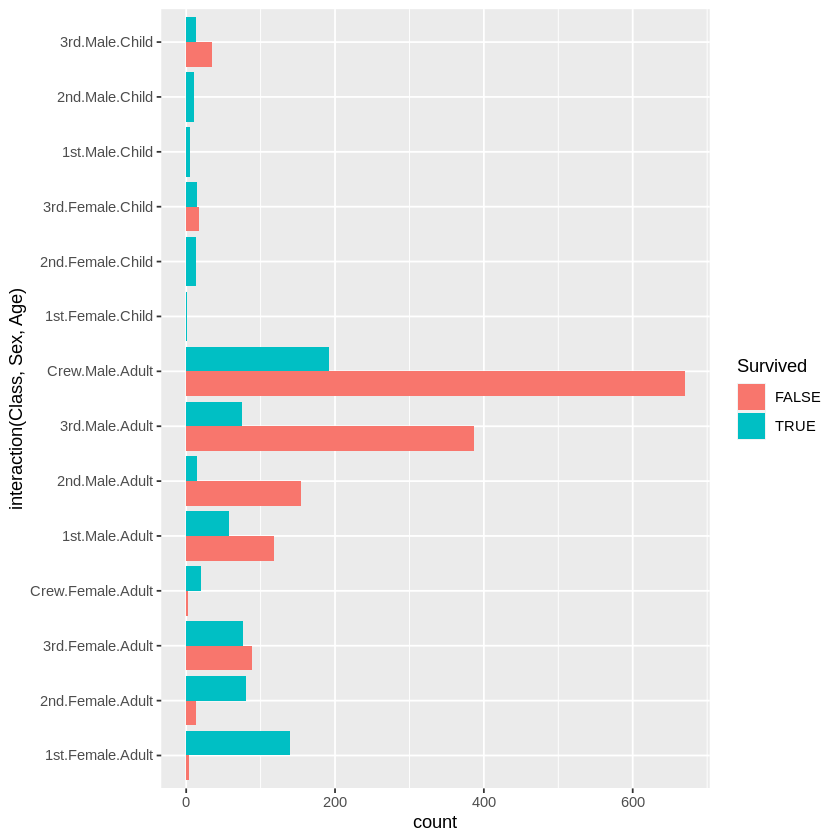

In [5]:
ggplot(titanic_df) + geom_bar(aes(x = interaction(Class, Sex, Age), fill = Survived), 
                              position = 'dodge') + coord_flip()

We have three categorical predictors: sex, age (adult / child), and class (1st-3rd or crew). Our outcome is also categorical: survived or not.

## Logistic regression
Suppose we want to build a regression model for predicting categorical outcomes.
In all of the regressions we have seen so far, the dependent ($y$) variable has been continuous: population growth, life expectancy, price, etc. However, there are many situations where the outcome is categorical. For simplicity, we will assume it's binary, and can be coded as 0/1. How should we model binary data?

One idea is to just stick what we know and use the linear model. Will this work?

In [5]:
mdl <- lm(Survived ~ Class + Sex + Age, data = titanic_df)
summary(mdl)


Call:
lm(formula = Survived ~ Class + Sex + Age, data = titanic_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.8930 -0.2268 -0.2163  0.2324  0.9044 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.89303    0.02585  34.546  < 2e-16 ***
Class2nd    -0.18608    0.03301  -5.637 1.95e-08 ***
Class3rd    -0.30673    0.02771 -11.070  < 2e-16 ***
ClassCrew   -0.17555    0.02797  -6.277 4.15e-10 ***
SexMale     -0.49068    0.02301 -21.329  < 2e-16 ***
AgeChild     0.18130    0.04097   4.425 1.01e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4047 on 2195 degrees of freedom
Multiple R-squared:  0.2529,	Adjusted R-squared:  0.2512 
F-statistic: 148.6 on 5 and 2195 DF,  p-value: < 2.2e-16


R did not generate any errors. But the regression looks "weird" in many ways:
- The $R$-squared low.
- The residual standard error is large relative to the outcome (which is always either zero or one).
- The residuals look weird:

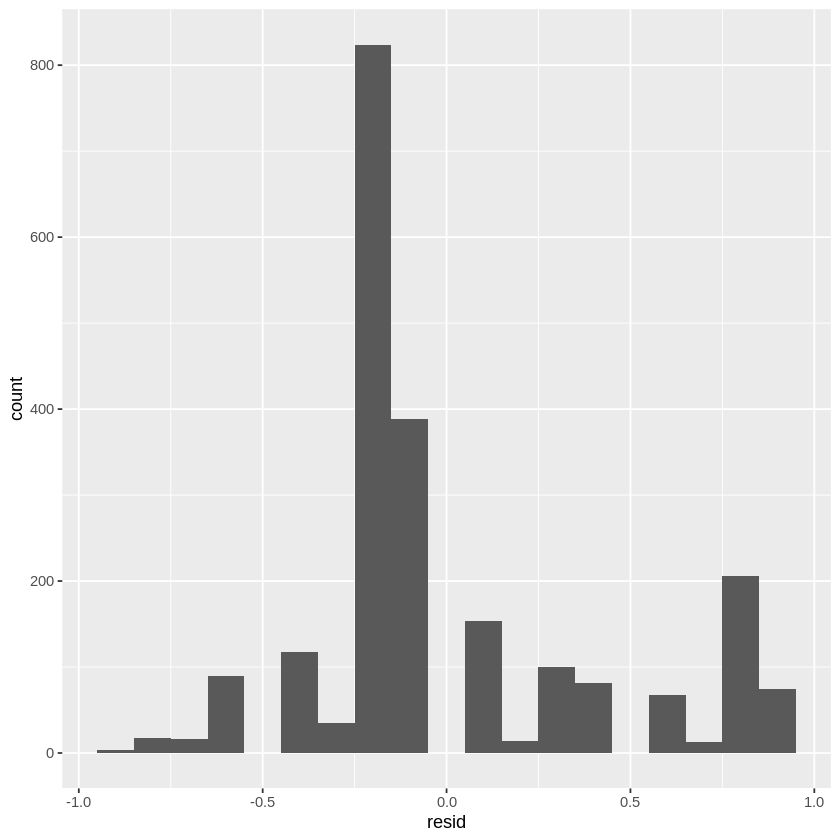

In [6]:
titanic_df %>% add_residuals(mdl) %>% mutate(resid=as.numeric(resid)) %>% 
    ggplot + geom_histogram(aes(x=resid), binwidth=.1)

What about predictions? The predicted outcomes are decimal numbers, whereas in the original model, the outcome was `TRUE` or `FALSE`.

In [7]:
titanic_df %>% add_predictions(mdl) %>% distinct %>% head

Class,Sex,Age,Survived,pred
<chr>,<chr>,<chr>,<lgl>,<dbl>
3rd,Male,Child,FALSE,0.2769110
3rd,Female,Child,FALSE,0.7675908
1st,Male,Adult,FALSE,0.4023497
2nd,Male,Adult,FALSE,0.2162696
3rd,Male,Adult,FALSE,0.0956153
Crew,Male,Adult,FALSE,0.2267959


The linear model says:

$$y = f(a + b x)$$ 

for $f(x)=x$. For 0/1 outcomes, let's instead try to think probabilistically:

$$\text{Prob}(y=1) = \underbrace{f(a + b x)}_{(\text{some function of the covariates})}$$

What criteria should this function $f$ have?
- It's range needs to be $[0,1]$.
- For "extreme" values of $a + bx$ it should tend to zero or one.

A function which satisfies both the properties is the **logistic function**:
$$f(x) = \frac{1}{1 + e^{-x}}.$$

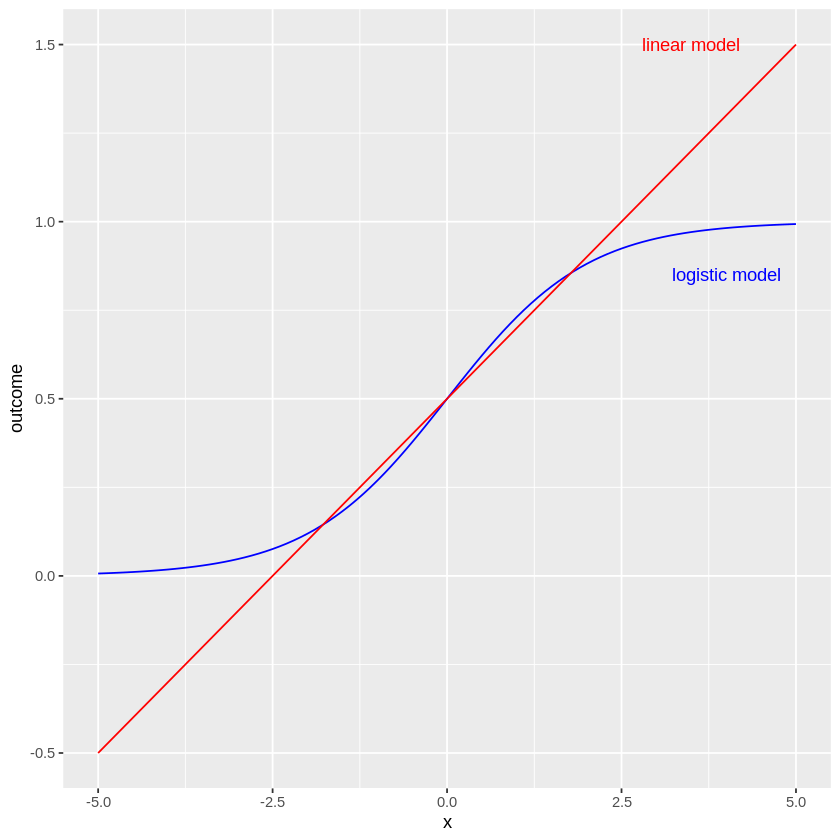

In [2]:
expand.grid(x = seq(-5, 5, .1)) %>% ggplot(aes(x = x)) + 
    stat_function(fun = function(x) (1 / (1 + exp(-x))), xlim = c(-5, 5), color = "blue") +
    stat_function(fun = function(x) 1/2 + x/5, xlim = c(-5, 5), color = "red") +
    annotate(x = 3.5, y = 1.5, geom = "text", label = "linear model", color = "red") +
    annotate(x = 4.0, y = .85, geom = "text", label = "logistic model", color = "blue") + 
    ylab("outcome")

For logistic model, you can see the outcome to be in the range of 0-1; predicted probability

To fit this model in R, we use a similar command as for linear regression: `glm()`. (The "g" stands for **g**eneralized linear model.) We'll start as we did with linear regression, using a single predictor:

In [6]:
mdl <- glm(Survived ~ Sex, data = titanic_df, family = "binomial")
#                                             ^^^^^^ important
mdl


Call:  glm(formula = Survived ~ Sex, family = "binomial", data = titanic_df)

Coefficients:
(Intercept)      SexMale  
      1.004       -2.317  

Degrees of Freedom: 2200 Total (i.e. Null);  2199 Residual
Null Deviance:	    2769 
Residual Deviance: 2335 	AIC: 2339

Although these results look similar to linear regression, their interpretation is quite different. Specifically, they are interpreted in terms of their effect on the *log-odds ratio*.

 The model we estimated above is 
 
 $$\log \left( \frac{p}{1-p} \right) = a_0 + a_1 \cdot \{\text{Male}\}$$

where $p$ is now the probability that a passenger survived

Let's confirm this by calculating the percentage of male passengers that survived:

In [30]:
titanic_df %>% count(Sex, Survived)

Sex,Survived,n
<chr>,<lgl>,<int>
Female,FALSE,126
Female,TRUE,344
Male,FALSE,1364
Male,TRUE,367


In [31]:
367 / (1364 + 367)

344 / (126 + 344)

[1] 0.2120162

[1] 0.7319149

The odds of survival by gender were:

In [10]:
odds <- c(male = .212 / .788, female = .731 / .268)
log(odds)

male    female 
-1.312912  1.003426

In [37]:
coef(mdl)[[1]]

[1] 1.00436

In [35]:
coef(mdl)

(Intercept)     SexMale 
   1.004360   -2.317175

Let us confirm the predictions are indeed the log-odds ratio

In [11]:
titanic_df %>% add_predictions(mdl) %>% count(pred)

pred,n
<dbl>,<int>
-1.312815,1731
1.004360,470


### The logistic function
The logistic function is $\sigma(x) = 1 / (1 + e^{-x})$. It is the inverse of the log-odds function:

$$\sigma \left( \log \frac{p}{1-p} \right) = p.$$

So, to calculate predicted probabilities from the log-odds, we apply the $\sigma(x)$ function to the predicted log-odds:

In [13]:
sigma <- function(x) 1 / (1 + exp(-x))
sigma(coef(mdl)[[1]])  # probability of survival for females
sigma(sum(coef(mdl)))  # probability of survival for males

[1] 0.7319149

[1] 0.2120162

In [56]:
sigma(log(0.21/(1-0.21)))

[1] 0.21

### Continuous predictor
Now let's consider logistic regression using a continuous predictor. To do this we'll download a richer version of this dataset which includes age as a number, instead of just classifying each passenger as adult or child:

In [16]:
titanic_df2 <- read_csv('https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv')
titanic_df2 %>% print

Rows: 891 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): Name, Sex, Ticket, Cabin, Embarked
dbl (7): PassengerId, Survived, Pclass, Age, SibSp, Parch, Fare

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# A tibble: 891 × 12
   PassengerId Survived Pclass Name   Sex     Age SibSp Parch Ticket  Fare Cabin
         <dbl>    <dbl>  <dbl> <chr>  <chr> <dbl> <dbl> <dbl> <chr>  <dbl> <chr>
 1           1        0      3 Braun… male     22     1     0 A/5 2…  7.25 NA   
 2           2        1      1 Cumin… fema…    38     1     0 PC 17… 71.3  C85  
 3           3        1      3 Heikk… fema…    26     0     0 STON/…  7.92 NA   
 4           4        1      1 Futre… fema…    35     1     0 113803 53.1  C123 
 5           5        0      3 Allen… male     35     0     0 373450  8.05 NA   
 6           6        0      3 Moran… male     NA     0     0 330877  8.46 NA   
 7           7        0      1 McCar… male     54     0     0 17463  51.9  E46  
 8           8        0      3 Palss… male      2     3     1 349909 21.1  NA   
 9           9        1      3 Johns… fema…    27     0     2 347742 11.1  NA   
10          10        1      2 Nasse… fema…    14     1     0 237736 30.1  NA   
# ℹ 881

In [17]:
mdl <- glm(Survived ~ Age, data = titanic_df2, family = "binomial")
summary(mdl)


Call:
glm(formula = Survived ~ Age, family = "binomial", data = titanic_df2)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)  
(Intercept) -0.05672    0.17358  -0.327   0.7438  
Age         -0.01096    0.00533  -2.057   0.0397 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 964.52  on 713  degrees of freedom
Residual deviance: 960.23  on 712  degrees of freedom
  (177 observations deleted due to missingness)
AIC: 964.23

Number of Fisher Scoring iterations: 4


Now our regression model is

$$\log \left( \frac{p}{1-p} \right) = a_0 + a_1 \cdot \text{Age}.$$

## 🤔 Quiz

```
Call:
glm(formula = Survived ~ Age, family = "binomial")


Coefficients:
            Estimate Std. Error z value Pr(>|z|)  
(Intercept) -0.05672    0.17358  -0.327   0.7438  
Age         -0.01096    0.00533  -2.057   0.0397 *
```



According to the model, what is the predicted probability that an 80-year-old senior survived the sinking of the Titanic?

<ol style="list-style-type: upper-alpha;">
    <li>&lt; 30%</li>
    <li>30-60%</li>
    <li>60-80%</li>
    <li>80-90%</li>
    <li>&gt; 90%</li>
</ol>

### Visualizing the model 

There are a few ways we can visualize the output of logistic regression. With one continuous predictor, we can directly compare the predicted probability with the predictor value:

Warning message:
“Removed 177 rows containing missing values (`geom_line()`).”


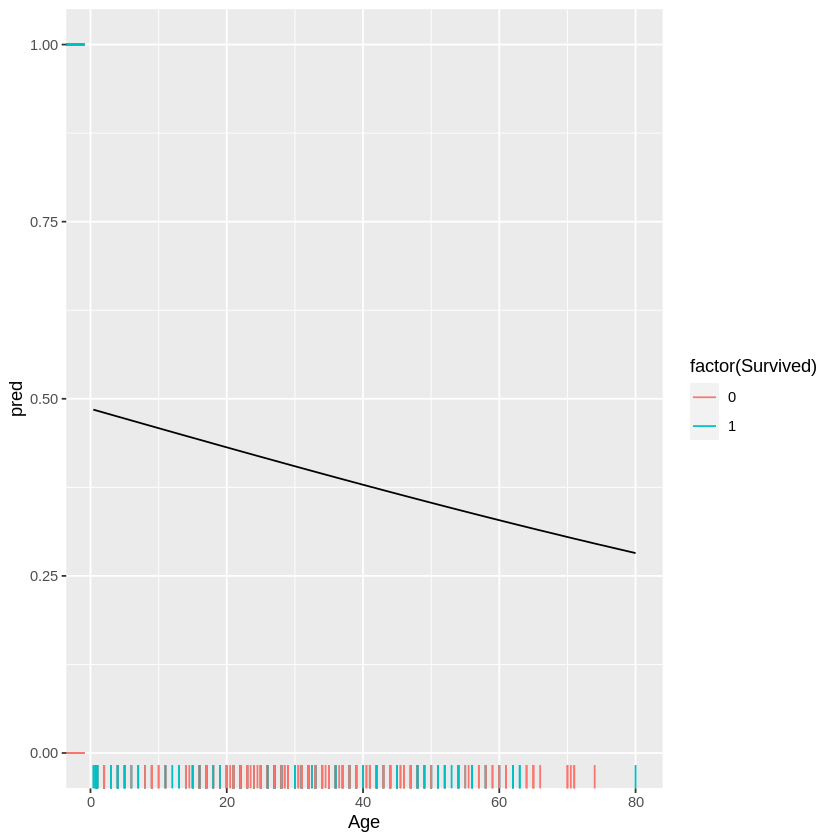

In [40]:
titanic_df2 %>% add_predictions(mdl, type = "response")  %>% 
    ggplot() + geom_line(aes(x = Age, y = pred)) +
    geom_rug(aes(x = Age, y = Survived, color = factor(Survived)))

### Logistic regression with multiple predictors

Just like with linear regression, multiple predictors can be added to logistic regression. The predicted log-odds become a multilinear function of the predictors:

$$\log \left( \frac{p}{1-p} \right) = a_0 + a_1 x_1 + \cdots + a_k x_k $$

In [42]:
mdl <- glm(Survived ~ Class + Age + Sex, data = titanic_df, family = "binomial")
#                                                           ^^^^^^ important! 
summary(mdl)


Call:
glm(formula = Survived ~ Class + Age + Sex, family = "binomial", 
    data = titanic_df)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)   2.0438     0.1679  12.171  < 2e-16 ***
Class2nd     -1.0181     0.1960  -5.194 2.05e-07 ***
Class3rd     -1.7778     0.1716 -10.362  < 2e-16 ***
ClassCrew    -0.8577     0.1573  -5.451 5.00e-08 ***
AgeChild      1.0615     0.2440   4.350 1.36e-05 ***
SexMale      -2.4201     0.1404 -17.236  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 2769.5  on 2200  degrees of freedom
Residual deviance: 2210.1  on 2195  degrees of freedom
AIC: 2222.1

Number of Fisher Scoring iterations: 4


The model we are fitting here is:

$$\underbrace{ \log\left( \frac{p_\text{survival}}{1-p_\text{survival}}  \right)}_\text{log odds ratio} = 2.04-1.02\times\texttt{\{2nd class\}}+\cdots-2.42\times \texttt{male}$$

To be clear, the "model" for how the above data was generated is the following:
1. First, I use all the predictors to form the log-odds ratio. For example, for an adult, male, third-class passenger, the predicted log-odds ratio is:

In [43]:
titanic_df %>% add_predictions(mdl) %>% 
    filter(Class == "3rd", Sex == "Male", Age == "Adult") %>% head

Class,Sex,Age,Survived,pred
<chr>,<chr>,<chr>,<lgl>,<dbl>
3rd,Male,Adult,FALSE,-2.153985
3rd,Male,Adult,FALSE,-2.153985
3rd,Male,Adult,FALSE,-2.153985
3rd,Male,Adult,FALSE,-2.153985
3rd,Male,Adult,FALSE,-2.153985
3rd,Male,Adult,FALSE,-2.153985


2. The log-odds ratio is -2.153985. The predicted probability of survival is obtained by solving 

$$\log\left(\frac{p}{1-p}\right) = -2.153985$$ for $p$. 

To do this we apply the logistic function $f(x)=1/(1+e^{-x})$:

$$p = \frac{1}{1 + \exp(2.153985)} = .104$$




In [52]:
-2.15 %>% sigma

[1] 0.1043312

### ROC curve
With multiple predictors, we can no longer easily visualize the logistic regression model as we did above. However, there is a very useful visualization for assessing its performance as a classifier called the receiver operating characteric (ROC) curve. To understand what this represents, let's add the predicted probabilities to our model:

In [44]:
titanic_pred <- titanic_df %>% 
  add_predictions(mdl, type = "response") %>% 
    print

# A tibble: 2,201 × 5
   Class Sex   Age   Survived  pred
   <chr> <chr> <chr> <lgl>    <dbl>
 1 3rd   Male  Child FALSE    0.251
 2 3rd   Male  Child FALSE    0.251
 3 3rd   Male  Child FALSE    0.251
 4 3rd   Male  Child FALSE    0.251
 5 3rd   Male  Child FALSE    0.251
 6 3rd   Male  Child FALSE    0.251
 7 3rd   Male  Child FALSE    0.251
 8 3rd   Male  Child FALSE    0.251
 9 3rd   Male  Child FALSE    0.251
10 3rd   Male  Child FALSE    0.251
# ℹ 2,191 more rows


The output of logistic regression is a set of _probabilities_ (numbers between 0 and 1), whereas the observed value is either 0 or 1. To convert from probabilities to prediction of 0 or 1, most of use would probably use the common sense rule

> Predict that Survived=1 if the predicted probability of survival is > 1/2.

In [45]:
titanic_pred %>% mutate(Survived_hat = as.integer(pred > 1/2)) %>% head

Class,Sex,Age,Survived,pred,Survived_hat
<chr>,<chr>,<chr>,<lgl>,<dbl>,<int>
3rd,Male,Child,FALSE,0.2511586,0
3rd,Male,Child,FALSE,0.2511586,0
3rd,Male,Child,FALSE,0.2511586,0
3rd,Male,Child,FALSE,0.2511586,0
3rd,Male,Child,FALSE,0.2511586,0
3rd,Male,Child,FALSE,0.2511586,0


## Accuracy measurement using Confusion Matrix


<img src='https://ebooks.mobibootcamp.com/ml_ai/confusion_matrix.png' />


- True positive rate (tpr, a.k.a recall or sensitivity): The percentage of people who are predicted to survive who in fact survived.
  
In addition to above we'll also add 1 more measure:

- False positive rate (fpr): The percentage of people who are predicted to survive who in fact perished.




Note: True negative rate is also called specificity. Therefore False positive rate (fpr) is 1 - specificity


In [46]:
titanic_pred %>% mutate(
    Survived_hat = pred > .4,
    Perished = !Survived, 
    Perished_hat = !Survived_hat,
    tn = Perished_hat & Perished,  # true -
    tp = Survived & Survived_hat,  # true +
    fp = Survived_hat & Perished,  # false +
    fn = Perished_hat & Survived   # false -
) %>% summarize(
    fpr = sum(fp) / (sum(fp) + sum(tn)),  # fraction of true - incorrectly classified as +,
    tpr = sum(tp) / (sum(tp) + sum(fn))  # fraction of true + correctly classified as +
)

fpr,tpr
<dbl>,<dbl>
0.1637584,0.5864979


When we choose an extreme high value of the threshold, our classification rule always predicts:
* `Survival = 0`, so it has a false-positive rate of zero. This is good; we want our classifier to make as few false-positive predictions as possible. 

* However, it also has a **true positive rate of zero!** So it has no power to correctly predict that any of the true survivors in fact survived.

Conversely, when we choose an extremely low value, it always predicts survival, so `TPR = FPR = 1`.

From the preceding discussion, we see that, given any probabilistic classifier, we can always make it have $\text{FPR}=\text{TPR}=1$ or $\text{FPR}=\text{TPR}=0$ by choosing an extreme probability cutoff. In other words, there is a tradeoff between having a good (i.e. close to zero) false-positive rate and a good (i.e. close to 1) true positive rate.

The ROC curve is a visual summary of this tradeoff. It plots the false positive rate on the $x$-axis, and the true positive rate on the $y$ axis. 

In [47]:
#install.packages("ROCR")
library(pROC)
# roc_curve = roc(!titanic_pred$Survived, titanic_pred$pred)
# roc_curve
library(ROCR)

### Area under curve
A useful summary of the ROC curve is the area under the curve (AUC), which ranges between 0.5 and 1. A classifier that has AUC=1 can perfectly classify the data since it achieves TPR=1 and FPR=0.

In [48]:
auc <- round(auc(titanic_pred$Survived, titanic_pred$pred), 4)

Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases



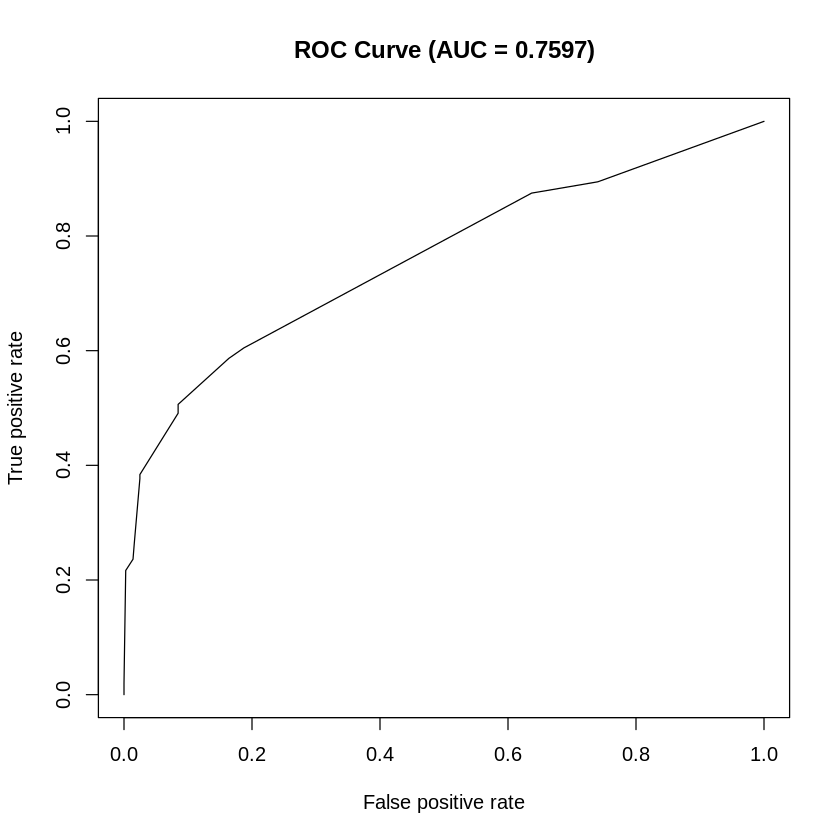

In [49]:
pred1 <- prediction(predict(mdl), titanic_pred$Survived)
perf1 <- performance(pred1,"tpr","fpr")
plot(perf1, main = paste0('ROC Curve ', '(AUC = ', auc, ')'))

### Precision or Recall - what to improve?

It all depends upon the use case. Let us find out what is more important in each of these scenarios:

## 🤔 Quiz
It is very important to diagnose cancer and any false negative result could cost a patient's life. An occasional false positive is acceptable as the patient will be subject to more tests before the treatment begins.
<ol style="list-style-type: upper-alpha;">
    <li>Improve Recall</li>
    <li>Improve Precision</li>
    <li>Improve Accuracy</li>
</ol>
  

## 🤔 Quiz

An ad agency wants to reach out to all possible repeat customers by sending out a mailer. A false positive will cost the agency the mailing cost but a false negative will result in loss of sales. Mailing cost is `$1` and loss of sales on average is `$10`. The ad agency is tight on the budget and its customers rate the agency based on how effective the mailers were.
<ol style="list-style-type: upper-alpha;">
    <li>Improve Recall</li>
    <li>Improve Precision</li>
    <li>Improve Accuracy</li>
</ol>
  

## 🤔 Quiz
In airport security screening not identifying a potential threat to the aircraft and there by passengers is very devastating.
<ol style="list-style-type: upper-alpha;">
    <li>Improve Recall</li>
    <li>Improve Precision</li>
    <li>Improve Accuracy</li>
</ol>
  

## 🤔 Quiz
In a credit card fraud detecting system a false positive will freeze a customer's credit card there by creating a lot of hardship to the customer and a false negative will allow the scammer to get away with fraud. Both the miss classifications are equally harmful
<ol style="list-style-type: upper-alpha;">
    <li>Improve Recall</li>
    <li>Improve Precision</li>
    <li>Improve Accuracy</li>
</ol>

Case study: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8831439/

### Building a good model
Last lecture, we saw how to create large, rich regression models by including more and more predictors in our regression. But we also saw that this could actually decrease predictive accuracy when analyzing data that the model had never seen before. 

Now, we will learn ways to systematically build a good model by dividing our data and using out-of-sample predictive performance to guide model selection.

The first step will be to divide our data into two sets, training and test.
- We will use the **training** set to train our model, and then
- The **testing** set will be used to judge how accurate it is on new data.

In [82]:
library(caTools)


# Split the dataset into training and test sets (70% train, 30% test)
set.seed(123) # For reproducibility
split <- sample.split(titanic_df$Survived, SplitRatio = 0.7)
train_data <- filter(titanic_df, split == TRUE)
test_data <- filter(titanic_df, split == FALSE)

# Perform logistic regression on the training data
log_model <- glm(Survived ~ ., data = train_data, family = binomial)

# Make predictions on the test set
test_data$predicted <- predict(log_model, newdata = test_data, type = "response")


# You can also calculate accuracy
accuracy <- mean(ifelse(test_data$Survived == 1 & test_data$predicted >= 0.5 |
                          test_data$Survived == 0 & test_data$predicted < 0.5, 1, 0))
cat("Accuracy:", accuracy * 100, "%\n")

Accuracy: 75.90909 %


## Intro to ANN

* Artificial Neural Network: Biologically-inspired (animal brain) programming paradigm that enables a computer to learn from data and is based on a collection of connected units called artificial neurons. Each connection between neurons can transmit a signal to another neuron. 
* Currently provide the best solutions to many problems in image recognition, speech recognition, and natural language processing.
* a typical ANN uses multiple layers of interconnected nodes to process input data
and generate output predictions by adjusting the weights and biases of the
connections between the neurons during the training process.

Review of HW: https://developers.google.com/machine-learning/crash-course/introduction-to-neural-networks/anatomy


In [85]:
install.packages('neuralnet')

also installing the dependency ‘Deriv’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [99]:
library(neuralnet)

# Create some dummy data for demonstration purposes
# This dataset consists of two input variables (X1 and X2) and one output variable (Y)
set.seed(123)
data <- data.frame(
  X1 = runif(100, 0, 1),
  X2 = runif(100, 0, 1)
) %>% mutate(Y = ifelse(X1 + X2 > 1, 1, 0))  # A simple logic function for output

nn <- neuralnet(Y ~ X1 + X2, data = data, hidden = 3)

In [98]:
nn

$call
neuralnet(formula = Y ~ X1 + X2, data = data, hidden = 3)

$response
    Y
1   0
2   1
3   0
4   1
5   1
6   0
7   1
8   1
9   0
10  0
11  1
12  0
13  0
14  1
15  0
16  1
17  0
18  0
19  0
20  1
21  1
22  1
23  0
24  1
25  1
26  1
27  0
28  0
29  0
30  0
31  1
32  1
33  1
34  1
35  0
36  1
37  1
38  1
39  1
40  0
41  0
42  0
43  0
44  0
45  0
46  0
47  0
48  0
49  0
50  1
51  0
52  0
53  1
54  0
55  0
56  0
57  0
58  0
59  1
60  0
61  1
62  0
63  1
64  0
65  1
66  0
67  1
68  1
69  1
70  0
71  1
72  0
73  1
74  0
75  1
76  0
77  0
78  1
79  1
80  0
81  1
82  0
83  1
84  1
85  0
86  0
87  1
88  1
89  1
90  1
91  0
92  0
93  1
94  1
95  1
96  0
97  1
98  0
99  0
100 1

$covariate
                 X1         X2
  [1,] 0.2875775201 0.59998896
  [2,] 0.7883051354 0.33282354
  [3,] 0.4089769218 0.48861303
  [4,] 0.8830174040 0.95447383
  [5,] 0.9404672843 0.48290240
  [6,] 0.0455564994 0.89035022
  [7,] 0.5281054880 0.91443819
  [8,] 0.8924190444 0.60873498
  [9,] 0.5514350145 0.410689